In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src")

import yaml
from omegaconf import OmegaConf
file_path = "../config/whistle.yaml"
with open(file_path, 'r') as file:
    config = OmegaConf.create(yaml.safe_load(file))

import torch
import numpy as np
torch.manual_seed(config.seed)
np.random.seed(config.seed)

## Dataset

In [3]:
from data import WhistleDataset

dataset = WhistleDataset(config)
dataset.summarize()

DATA LOADED!

N Examples: 111707
N Classes: 2
Classes: [0. 1.]
 - Class 0: 55850 (49.996866803333724)
 - Class 1: 55857 (50.00313319666628)


## Model

In [4]:
from models import WhistleNet, CCNN
# model = WhistleNet(config)
model = CCNN(in_channels=1, out_channels=1, config=config)

## Training

In [5]:
from core.trainer import Trainer
trainer = Trainer(config)
model.load()
trainer.fit(model,dataset)

MODEL LOADED!


Epoch 1, evaluating: 100%|██████████| 1554/1554 [00:08<00:00, 176.02it/s]

EPOCH 1 SCORE: 0.766 LOSS: 0.216
MODEL SAVED!


## Evaluation

MODEL LOADED!


,precision,recall,f1-score,support
0,0.990932,0.989501,0.990216,119156.000000
1,0.762664,0.788390,0.775313,5099.000000
accuracy,0.981248,0.981248,0.981248,0.981248
macro avg,0.876798,0.888946,0.882765,124255.000000
weighted avg,0.981564,0.981248,0.981397,124255.000000


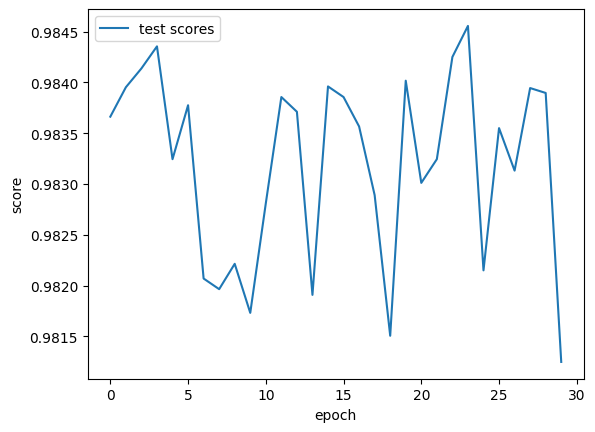

In [ ]:
import matplotlib.pyplot as plt

complete_plot = False
    
model.load()
model.evaluate(dataset, show=True)
plt.plot(model.test_scores, label='test scores')
plt.legend()
plt.ylabel('score')
plt.xlabel('epoch')
plt.show()

## Inference on test audio

frame 0, time 0.00
Prediction: tensor([[0.8606, 0.1394]]), elapsed: 0.0155
frame 1, time 0.02
Prediction: tensor([[0.7087, 0.2913]]), elapsed: 0.0036
frame 2, time 0.05
Prediction: tensor([[0.7056, 0.2944]]), elapsed: 0.0031
frame 3, time 0.07
Prediction: tensor([[0.7055, 0.2945]]), elapsed: 0.0031
frame 4, time 0.09
Prediction: tensor([[0.7068, 0.2932]]), elapsed: 0.0032
frame 5, time 0.12
Prediction: tensor([[0.7050, 0.2950]]), elapsed: 0.0036
frame 6, time 0.14
Prediction: tensor([[0.7048, 0.2952]]), elapsed: 0.0037
frame 7, time 0.16
Prediction: tensor([[0.7054, 0.2946]]), elapsed: 0.0034
frame 8, time 0.19
Prediction: tensor([[0.7021, 0.2979]]), elapsed: 0.0034
frame 9, time 0.21
Prediction: tensor([[0.6991, 0.3009]]), elapsed: 0.0034
frame 10, time 0.23
Prediction: tensor([[0.7031, 0.2969]]), elapsed: 0.0030
frame 11, time 0.26
Prediction: tensor([[0.6986, 0.3014]]), elapsed: 0.0025
frame 12, time 0.28
Prediction: tensor([[0.7000, 0.3000]]), elapsed: 0.0024
frame 13, time 0.30
Pr

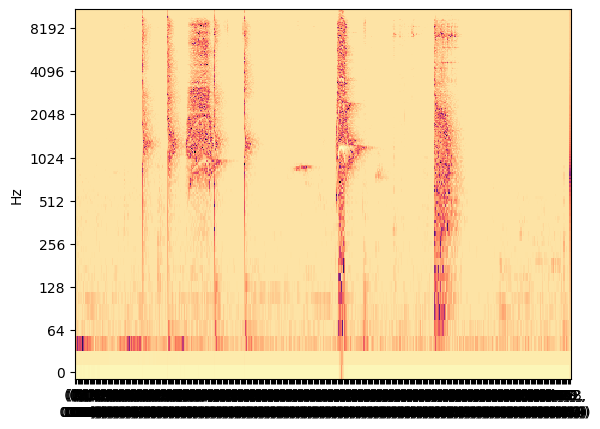

In [ ]:
import torch
from utils import Audio, project_root
import time

def classify(window):
    with torch.no_grad():
        start = time.time()
        prediction = torch.softmax(model(window), dim=1)
        elapsed = time.time() - start
        predicted_class = torch.argmax(prediction).item()
        print(f"Prediction: {prediction}, elapsed: {elapsed:.4f}")
        return predicted_class


projroot = project_root()
audio = Audio(name="test4", datapath=f'{projroot}/data/whistle/raw/test')
for i in range(audio.S.shape[1]):
    window = torch.from_numpy(audio.S[:,i].reshape(1,1,513))
    print(f"frame {i}, time {audio.frame2time(i):.2f}")
    classify(window)
audio.freq_plot()

## Export to ONNX

In [ ]:
from edge import ONNX

# onnx = ONNX(model)